In [44]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import argparse
import sys
import copy
import os
import glob
import scipy as sp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
import pickle
import time
#from util import *
#from ops import *
import multiprocessing
from multiprocessing import Pool
#from model import DCGAN
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#np.set_printoptions(threshold='nan')

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
#Setting up the dataset for ML
# Text file data converted to integer data type
x_data = np.loadtxt("dataset/x_dataTrain.txt", dtype=float)
print(x_data)

[[3.27030e-24 3.07616e-24 5.22539e-24 ... 1.32958e-21 1.33228e-21
  1.35562e-21]
 [1.30267e-20 1.30677e-20 1.31157e-20 ... 3.81686e-20 3.81212e-20
  3.80739e-20]
 [6.26322e-21 6.28294e-21 6.30602e-21 ... 1.83835e-20 1.83606e-20
  1.83378e-20]
 ...
 [2.18046e-21 2.18672e-21 2.19415e-21 ... 4.09628e-21 4.09113e-21
  4.08599e-21]
 [8.45625e-21 8.48075e-21 8.50976e-21 ... 1.65705e-20 1.65496e-20
  1.65289e-20]
 [9.18122e-27 9.43401e-27 1.16085e-26 ... 4.02891e-22 4.05835e-22
  4.14389e-22]]


In [4]:
#Setting up the dataset for ML
# Text file data converted to integer data type
y_data = np.loadtxt("dataset/y_dataTrain.txt", dtype=float)
print(y_data)

[[5.44779525e-02 3.63563344e-01 3.93226327e-01 ... 3.84039400e-03
  1.04632279e-03 8.05759487e-06]
 [4.16023007e-02 1.98831946e-01 3.19697149e-01 ... 1.58676888e-04
  2.70865681e-04 6.98852685e-06]
 [3.25809662e-02 3.30184164e-01 2.25277622e-01 ... 3.64259914e-04
  1.77938880e-05 5.15590766e-06]
 ...
 [6.00137545e-03 2.25446819e-01 2.36290974e-01 ... 3.41272939e-03
  1.68012889e-04 8.55777941e-06]
 [9.61424398e-03 2.41019755e-01 4.74460251e-01 ... 2.28148605e-03
  1.53862644e-04 3.59720563e-06]
 [1.48247666e-02 4.65782909e-01 3.00848722e-01 ... 5.70894991e-03
  1.74632155e-04 1.76412088e-06]]


In [5]:
feature_dict = {
    0 : 'H2O',
    1 : 'CO2',
    2 : 'O2',
    3 : 'N2',
    4 : 'CH4',
    5 : 'N2O',
    6 : 'CO',
    7 : 'O3',
    8 : 'SO2',
    9 : 'NH3',
    10 : 'C2H6',
    11 : 'NO2'
}

In [6]:
features = pd.DataFrame(x_data)
labels = pd.DataFrame(y_data)

In [7]:
labels.rename(columns=feature_dict,
          inplace=True)

array([[<AxesSubplot:title={'center':'N2'}>]], dtype=object)

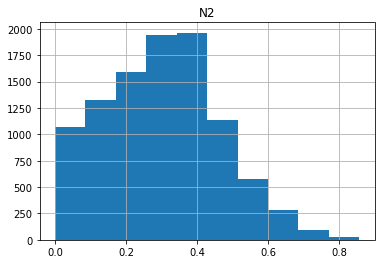

In [338]:
labelsSum = labels[['H2O','CO2', 'O2', 'N2', 'CH4']]
labelsSum.hist(column='N2')

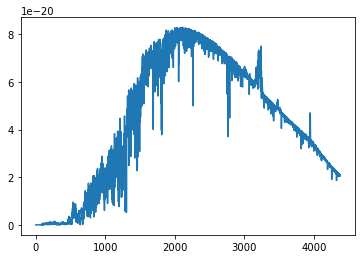

Surface Temperature:  1.90195e-23


In [431]:
plt.plot(features.iloc[89,:])
plt.show()
print('Surface Temperature: ', features.iloc[62,12])

In [339]:
#Splitting dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labelsSum, test_size=0.33, random_state=42)

In [290]:
scaler = StandardScaler()
X_scaledTrain = scaler.fit_transform(X_train)
X_scaledTest = scaler.fit_transform(X_test)

In [340]:
y_scaler = StandardScaler()
y_scaledTrain = scaler.fit_transform(y_train)
y_scaledTest = scaler.fit_transform(y_test)

In [429]:
#Applying PCA for random forest regression
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(X_scaledTrain)
principalDf = pd.DataFrame(data = principalComponents)

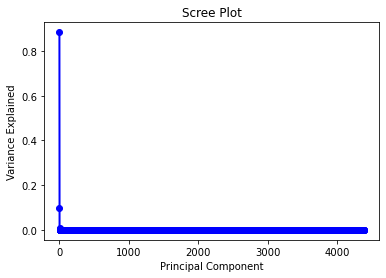

In [432]:
#Graphing scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [398]:
pca_features = pca.explained_variance_ratio_[:10]

# Testing Neural Network Regression Model

In [446]:
#Creating Neural Network model
exoAtmos = Sequential()

exoAtmos.add(Dense(128, kernel_initializer='he_uniform',input_dim = X_scaledTest.shape[1], activation='relu'))
exoAtmos.add(BatchNormalization())


# The Hidden Layers :
exoAtmos.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
exoAtmos.add(BatchNormalization())
exoAtmos.add(Dropout(0.10))

exoAtmos.add(Dense(512, kernel_initializer='he_uniform',activation='relu'))
exoAtmos.add(BatchNormalization())
exoAtmos.add(Dropout(0.10))

exoAtmos.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
exoAtmos.add(BatchNormalization())
exoAtmos.add(Dropout(0.10))

exoAtmos.add(Dense(128, kernel_initializer='he_uniform',activation='relu'))
exoAtmos.add(BatchNormalization())

# The Output Layer :
exoAtmos.add(Dense(5))

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
# Compile the network :
exoAtmos.compile(loss='mae', optimizer=opt)
exoAtmos.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 128)               560512    
_________________________________________________________________
batch_normalization_47 (Batc (None, 128)               512       
_________________________________________________________________
dense_198 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_48 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 512)               131584    
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)             

In [447]:
#Training the model
history = exoAtmos.fit(X_scaledTest, y_scaledTrain, epochs=100, batch_size=32, validation_split = 0.2)

Epoch 1/100
83/83 [==============================] - 2s 13ms/step - loss: 1.1556 - accuracy: 0.2019 - val_loss: 0.9128 - val_accuracy: 0.2617
Epoch 2/100
83/83 [==============================] - 1s 10ms/step - loss: 1.0161 - accuracy: 0.1951 - val_loss: 0.8700 - val_accuracy: 0.2163
Epoch 3/100
83/83 [==============================] - 1s 10ms/step - loss: 0.9515 - accuracy: 0.2091 - val_loss: 0.8431 - val_accuracy: 0.1967
Epoch 4/100
83/83 [==============================] - 1s 10ms/step - loss: 0.9131 - accuracy: 0.2011 - val_loss: 0.8592 - val_accuracy: 0.2315
Epoch 5/100
83/83 [==============================] - 1s 9ms/step - loss: 0.8787 - accuracy: 0.2152 - val_loss: 0.8339 - val_accuracy: 0.2254
Epoch 6/100
83/83 [==============================] - 1s 9ms/step - loss: 0.8678 - accuracy: 0.2057 - val_loss: 0.8425 - val_accuracy: 0.1483
Epoch 7/100
83/83 [==============================] - 1s 9ms/step - loss: 0.8552 - accuracy: 0.2178 - val_loss: 0.8221 - val_accuracy: 0.2269
Epoch 8/1

83/83 [==============================] - 1s 9ms/step - loss: 0.7846 - accuracy: 0.2769 - val_loss: 0.8018 - val_accuracy: 0.2905
Epoch 59/100
83/83 [==============================] - 1s 9ms/step - loss: 0.7830 - accuracy: 0.2655 - val_loss: 0.8013 - val_accuracy: 0.2844
Epoch 60/100
83/83 [==============================] - 1s 8ms/step - loss: 0.7824 - accuracy: 0.2864 - val_loss: 0.8014 - val_accuracy: 0.2799
Epoch 61/100
83/83 [==============================] - 1s 8ms/step - loss: 0.7829 - accuracy: 0.2773 - val_loss: 0.8026 - val_accuracy: 0.2769
Epoch 62/100
83/83 [==============================] - 1s 9ms/step - loss: 0.7829 - accuracy: 0.2788 - val_loss: 0.8038 - val_accuracy: 0.2769
Epoch 63/100
83/83 [==============================] - 1s 9ms/step - loss: 0.7824 - accuracy: 0.2814 - val_loss: 0.8005 - val_accuracy: 0.3071
Epoch 64/100
83/83 [==============================] - 1s 9ms/step - loss: 0.7849 - accuracy: 0.2705 - val_loss: 0.8009 - val_accuracy: 0.2965
Epoch 65/100
83/83 

In [448]:
#Evaluating the model
mae = exoAtmos.evaluate(X_scaledTest, y_scaledTest, verbose=0)

In [449]:
print('>%.3f' % mae[0])

>0.791


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


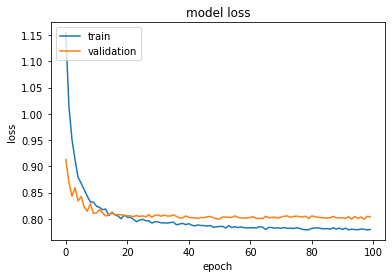

In [450]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [428]:
from sklearn.metrics import mean_squared_error
ypred = exoAtmos.predict(X_scaledTest)
print("y1 MSE:%.4f" % mean_squared_error(y_scaledTest[:,0], ypred[:,0])) 
print("y2 MSE:%.4f" % mean_squared_error(y_scaledTest[:,1], ypred[:,1]))
print("y3 MSE:%.4f" % mean_squared_error(y_scaledTest[:,2], ypred[:,2]))
print("y4 MSE:%.4f" % mean_squared_error(y_scaledTest[:,3], ypred[:,3]))
print("y5 MSE:%.4f" % mean_squared_error(y_scaledTest[:,4], ypred[:,4]))

y1 MSE:1.0429
y2 MSE:1.0124
y3 MSE:1.0382
y4 MSE:1.0167
y5 MSE:1.0288


# 1D CNN with Keras

In [352]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical

In [353]:
print(X_scaledTrain.shape)
print(X_scaledTrain[0].shape)
print(len(X_scaledTrain[0]))

(6702, 4378)
(4378,)
4378


In [354]:
#Convert features into timesteps
sample_size = X_scaledTrain.shape[0]
time_steps = X_scaledTrain.shape[1]
input_dimension = 1

X_reTrain = X_scaledTrain.reshape(sample_size, time_steps, input_dimension)
X_reTest = X_scaledTest.reshape(X_scaledTest.shape[0], X_scaledTest.shape[1], input_dimension)

print(X_reTrain.shape)
print(X_reTrain[0].shape)
print((X_reTrain[0]))

(6702, 4378, 1)
(4378, 1)
[[ 0.64027712]
 [ 0.63970607]
 [ 0.63816855]
 ...
 [-0.15958483]
 [-0.15980762]
 [-0.16226966]]


In [415]:
#def convModel():
n_timesteps = X_reTrain.shape[1]
n_features = X_reTrain.shape[2]
model = Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Dropout(0.35))
    
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
    
model.add(Dense(32, activation='relu'))
model.add(Dense(5))
    
opt = tf.keras.optimizers.RMSprop(0.001)
    
model.compile(loss='mse', optimizer=opt, metrics=['mae','accuracy'])

In [416]:
hist=model.fit(X_reTrain, y_scaledTrain, epochs=50,
                    validation_split=0.2)

Epoch 1/50
168/168 [==============================] - 113s 670ms/step - loss: 2.2777 - mae: 0.8445 - accuracy: 0.2056 - val_loss: 0.9993 - val_mae: 0.7815 - val_accuracy: 0.0984
Epoch 2/50
168/168 [==============================] - 109s 651ms/step - loss: 1.0158 - mae: 0.7867 - accuracy: 0.2179 - val_loss: 0.9997 - val_mae: 0.7812 - val_accuracy: 0.2558
Epoch 3/50
168/168 [==============================] - 114s 680ms/step - loss: 1.0003 - mae: 0.7835 - accuracy: 0.2667 - val_loss: 0.9998 - val_mae: 0.7811 - val_accuracy: 0.2610
Epoch 4/50
168/168 [==============================] - 116s 689ms/step - loss: 1.0003 - mae: 0.7834 - accuracy: 0.2574 - val_loss: 0.9997 - val_mae: 0.7812 - val_accuracy: 0.2610
Epoch 5/50
168/168 [==============================] - 125s 742ms/step - loss: 1.0003 - mae: 0.7835 - accuracy: 0.2666 - val_loss: 0.9997 - val_mae: 0.7811 - val_accuracy: 0.2610
Epoch 6/50
168/168 [==============================] - 126s 750ms/step - loss: 1.0002 - mae: 0.7834 - accuracy:

KeyboardInterrupt: 

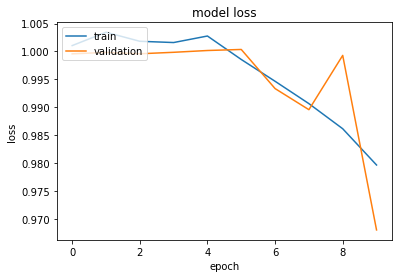

In [372]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [440]:
pca_features = pca.explained_variance_ratio_[:10]
x_pcTrain = pca.fit_transform(X_scaledTrain)[:,:10]

In [441]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [439]:
regr.fit(x_pcTrain, y_scaledTrain)

KeyboardInterrupt: 